# Loading the Data

In [1]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from keras.regularizers import l2
from tensorflow.keras.applications import Xception
import cv2
from skimage.filters import threshold_otsu
from skimage.restoration import wiener
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from skimage.restoration import wiener
import pywt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_meta = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/meta.csv')
df_meta.head()

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,Visibility,ImageCount
0,1.3.6.1.4.1.9590.100.1.2.117041576511324414842...,1.3.6.1.4.1.9590.100.1.2.229361142710768138411...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
1,1.3.6.1.4.1.9590.100.1.2.438738396107617880132...,1.3.6.1.4.1.9590.100.1.2.195593486612988388325...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
2,1.3.6.1.4.1.9590.100.1.2.767416741131676463382...,1.3.6.1.4.1.9590.100.1.2.257901172612530623323...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
3,1.3.6.1.4.1.9590.100.1.2.296931352612305599800...,1.3.6.1.4.1.9590.100.1.2.109468616710242115222...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
4,1.3.6.1.4.1.9590.100.1.2.436657670120353100077...,1.3.6.1.4.1.9590.100.1.2.380627129513562450304...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2


In [3]:
# load dicom info file
df_dicom = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')
df_dicom.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [4]:
# check image types in dataset
df_dicom.SeriesDescription.unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

In [5]:
# check image path in dataset
# cropped images
cropped_images = df_dicom[df_dicom.SeriesDescription=='cropped images'].image_path
#cropped_images.head(5)

In [6]:
#full mammogram images
full_mammo = df_dicom[df_dicom.SeriesDescription=='full mammogram images'].image_path
#full_mammo.head(5)

In [7]:
# ROI images
roi_img = df_dicom[df_dicom.SeriesDescription=='ROI mask images'].image_path
#roi_img.head(5)

In [8]:
# set correct image path for image types
imdir = '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

In [9]:
# change directory path of images
cropped_images = cropped_images.replace('CBIS-DDSM/jpeg', imdir, regex=True)
full_mammo = full_mammo.replace('CBIS-DDSM/jpeg', imdir, regex=True)
roi_img = roi_img.replace('CBIS-DDSM/jpeg', imdir, regex=True)

# view new paths
print('Cropped Images paths:\n')
print(cropped_images.iloc[0])
print('Full mammo Images paths:\n')
print(full_mammo.iloc[0])
print('ROI Mask Images paths:\n')
print(roi_img.iloc[0])

Cropped Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Full mammo Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI Mask Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [10]:
# organize image paths
full_mammo_dict = dict()
cropped_images_dict = dict()
roi_img_dict = dict()

for dicom in full_mammo:
    key = dicom.split("/")[4]
    full_mammo_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[4]
    cropped_images_dict[key] = dicom
for dicom in roi_img:
    key = dicom.split("/")[4]
    roi_img[key] = dicom

# view keys
next(iter((full_mammo_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

# Mass Dataset

In [11]:
# load the mass dataset
mass_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')

mass_train.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [12]:
# fix image paths
def fix_image_path(data):
    """correct dicom paths to correct image paths"""
    for index, img in enumerate(data.values):
        img_name = img[11].split("/")[2]
        data.iloc[index,11] = full_mammo_dict[img_name]
        img_name = img[12].split("/")[2]
        data.iloc[index,12] = cropped_images_dict[img_name]
        
# apply to datasets
fix_image_path(mass_train)
fix_image_path(mass_test)

In [13]:
# check unique values in pathology column
mass_train.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [14]:
mass_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

In [15]:
# rename columns
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

mass_train.head(5)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [16]:
# check for null values
mass_train.isnull().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality_id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image_file_path             0
cropped_image_file_path     0
ROI_mask_file_path          0
dtype: int64

In [17]:
# fill in missing values using the backwards fill method
mass_train['mass_shape'] = mass_train['mass_shape'].fillna(method='bfill')
mass_train['mass_margins'] = mass_train['mass_margins'].fillna(method='bfill')

#check null values
mass_train.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [18]:
# quantitative summary of features
mass_train.describe()

,breast_density,abnormality_id,assessment,subtlety
count,1318.000000,1318.000000,1318.000000,1318.000000
mean,2.203338,1.116085,3.504552,3.965857
std,0.873774,0.467013,1.414609,1.102032
min,1.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,3.000000,3.000000
50%,2.000000,1.000000,4.000000,4.000000
75%,3.000000,1.000000,4.000000,5.000000
max,4.000000,6.000000,5.000000,5.000000


In [19]:
# view mass_test
mass_test.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....


In [20]:
# check datasets shape
print(f'Shape of mass_train: {mass_train.shape}')
print(f'Shape of mass_test: {mass_test.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [21]:
mass_test.isnull().sum()

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  0
mass margins               17
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [22]:
# check for column names in mass_test
print(mass_test.columns)
print('\n')
# rename columns
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

# view renamed columns
mass_test.columns

Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'mass shape', 'mass margins',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')




Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality_id', 'abnormality_type', 'mass_shape', 'mass_margins',
       'assessment', 'pathology', 'subtlety', 'image_file_path',
       'cropped_image_file_path', 'ROI_mask_file_path'],
      dtype='object')

In [23]:
# fill in missing values using the backwards fill method
mass_test['mass_margins'] = mass_test['mass_margins'].fillna(method='bfill')

#check null values
mass_test.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

# Visualizations

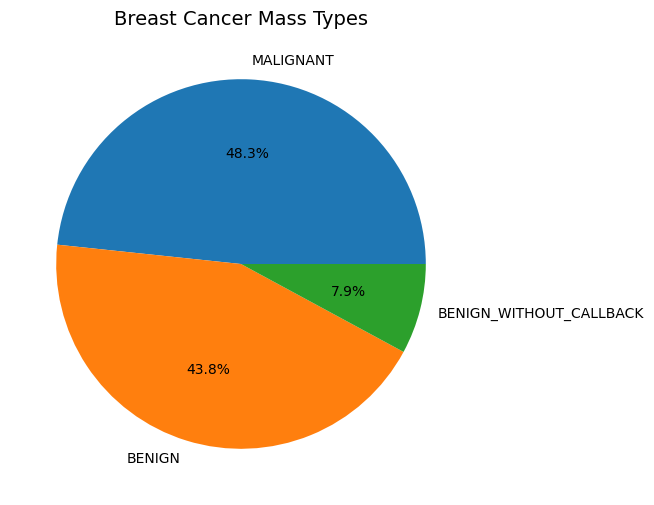

In [24]:
# pathology distributions
value = mass_train['pathology'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Breast Cancer Mass Types', fontsize=14)
plt.savefig('/kaggle/working/pathology_distributions_red.png')
plt.show()

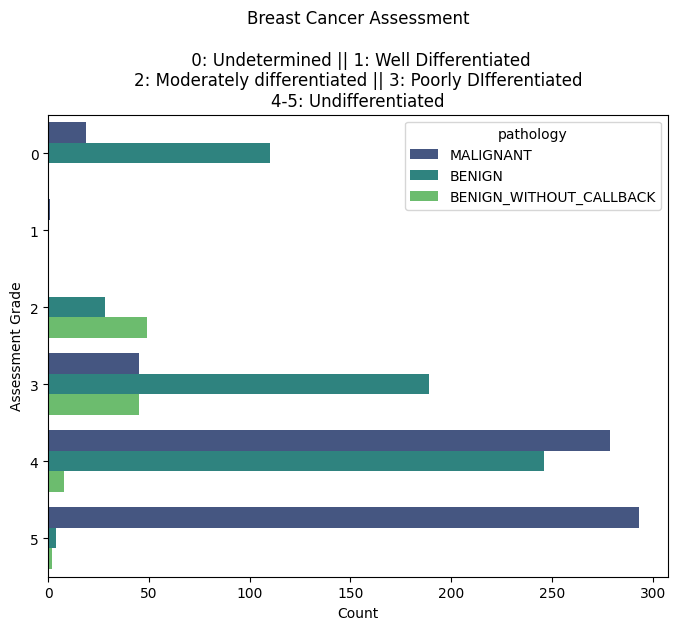

In [25]:
# examine breast assessment types
plt.figure(figsize=(8,6))
sns.countplot(mass_train, y='assessment', hue='pathology', palette='viridis')
plt.title('Breast Cancer Assessment\n\n 0: Undetermined || 1: Well Differentiated\n2: Moderately differentiated || 3: Poorly DIfferentiated\n4-5: Undifferentiated', 
          fontsize=12)
plt.ylabel('Assessment Grade')
plt.xlabel('Count')
plt.savefig('/kaggle/working/breast_assessment_red.png')
plt.show()

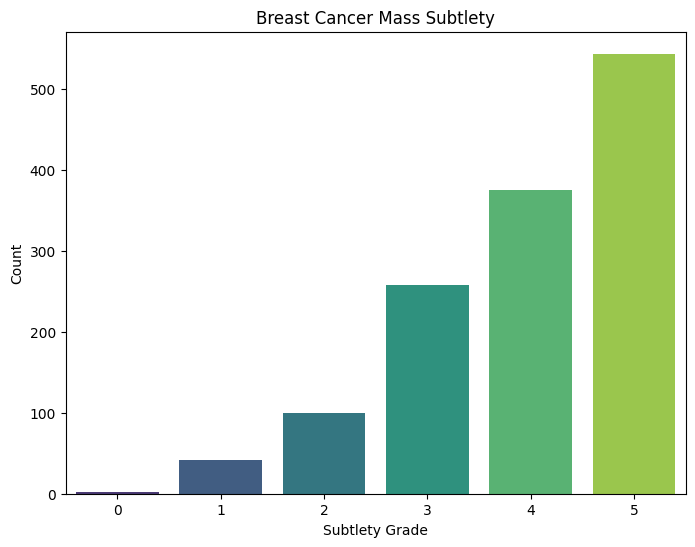

In [26]:
# examine cancer subtlety
plt.figure(figsize=(8,6))
sns.countplot(mass_train, x='subtlety', palette='viridis')
plt.title('Breast Cancer Mass Subtlety', fontsize=12)
plt.xlabel('Subtlety Grade')
plt.ylabel('Count')
plt.savefig('/kaggle/working/cancer_subtlety_red.png')
plt.show()

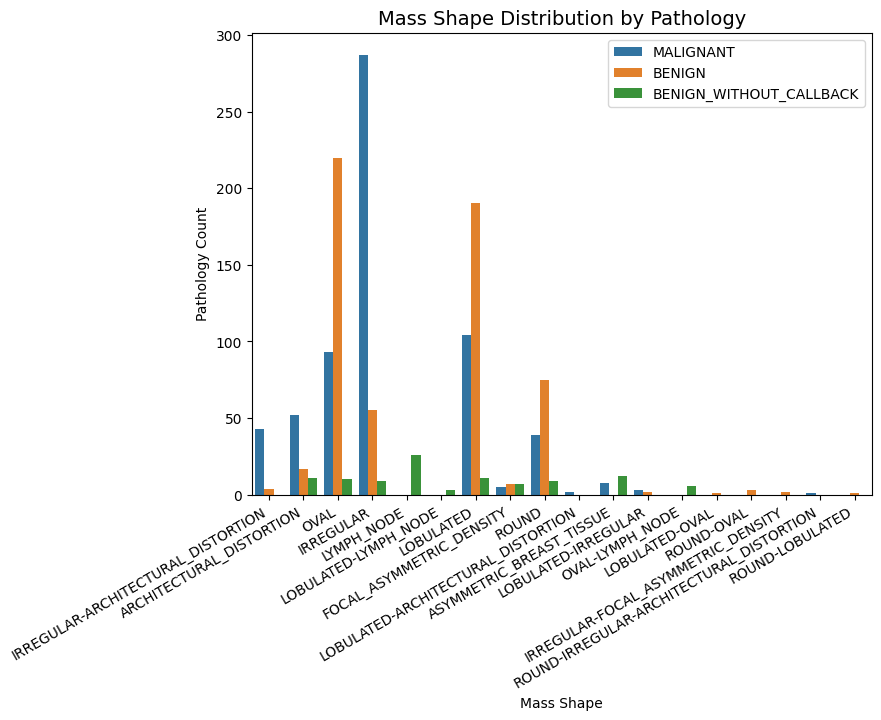

In [27]:
# view breast mass shape distribution against pathology
plt.figure(figsize=(8,6))

sns.countplot(mass_train, x='mass_shape', hue='pathology')
plt.title('Mass Shape Distribution by Pathology', fontsize=14)
plt.xlabel('Mass Shape')
plt.xticks(rotation=30, ha='right')


plt.ylabel('Pathology Count')
plt.legend()
plt.savefig('/kaggle/working/mass_pathology_red.png')
plt.show()

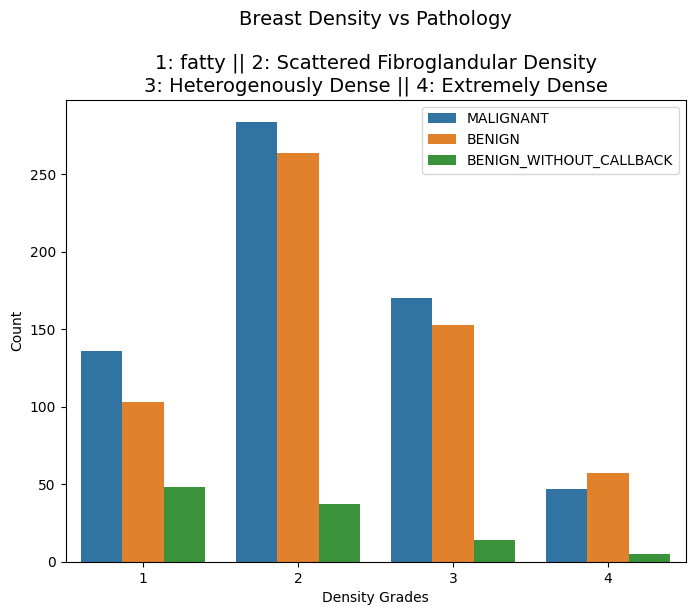

In [28]:
# breast density against pathology
plt.figure(figsize=(8,6))

sns.countplot(mass_train, x='breast_density', hue='pathology')
plt.title('Breast Density vs Pathology\n\n1: fatty || 2: Scattered Fibroglandular Density\n3: Heterogenously Dense || 4: Extremely Dense',
          fontsize=14)
plt.xlabel('Density Grades')
plt.ylabel('Count')
plt.legend()
plt.savefig('/kaggle/working/density_pathology_red.png')
plt.show()

Full Mammograms:



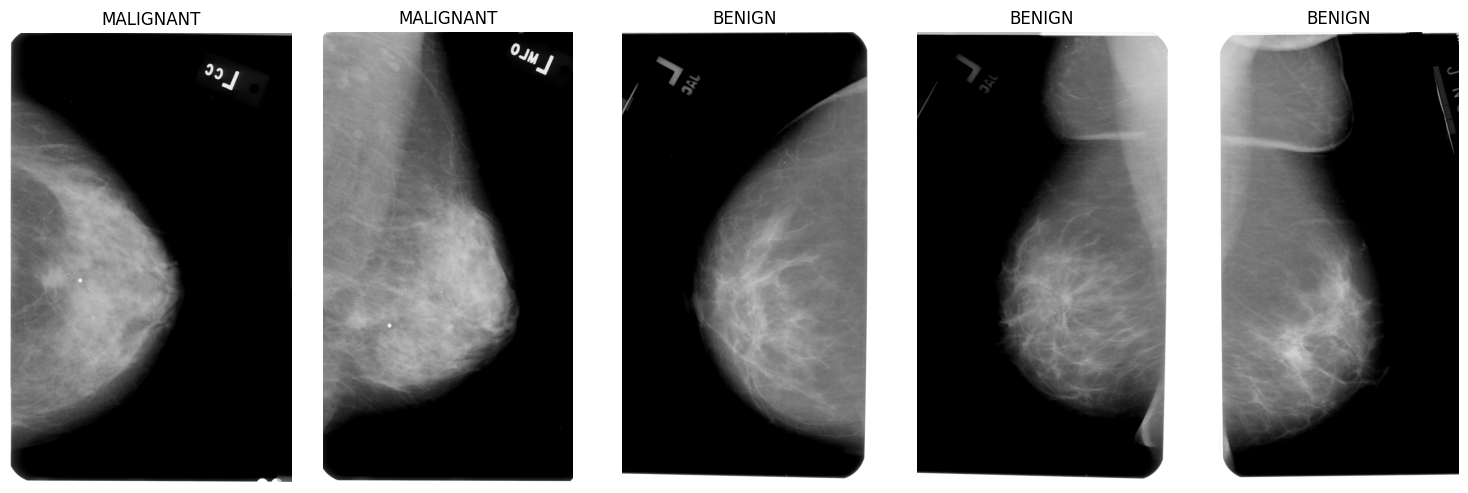

Cropped Mammograms:



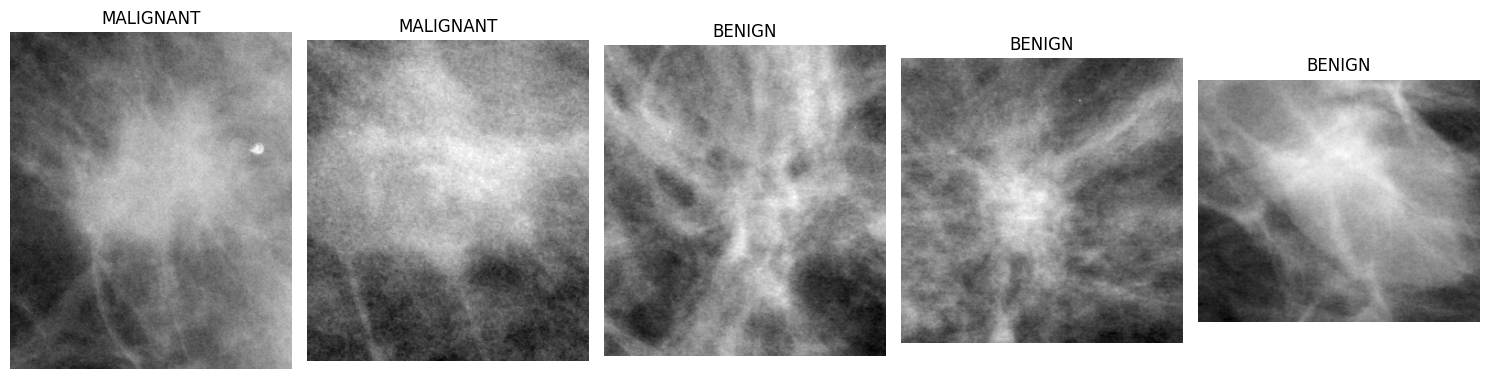

In [29]:
# Display some images
import matplotlib.image as mpimg

# create function to display images
def display_images(column, number):
    """displays images in dataset"""
    # create figure and axes
    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    
    # Loop through rows and display images
    for index, row in mass_train.head(number_to_visualize).iterrows():
        image_path = row[column]
        image = mpimg.imread(image_path)
        ax = axes[index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print('Full Mammograms:\n')
display_images('image_file_path', 5)
print('Cropped Mammograms:\n')
display_images('cropped_image_file_path', 5)

# Preprocessing of Images

In [30]:
import tensorflow as tf
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# Import necessary TensorFlow libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

def image_processor(image_path, target_size):
    """Preprocess images for ResNet101 model"""
    absolute_image_path = os.path.abspath(image_path)
    image = cv2.imread(absolute_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (target_size[1], target_size[0]))
    image_array = image / 255.0
    return image_array

# Merge datasets
full_mass = pd.concat([mass_train, mass_test], axis=0)

# Define the target size
target_size = (224, 224, 3)

# Apply preprocessor to train data
full_mass['processed_images'] = full_mass['image_file_path'].apply(lambda x: image_processor(x, target_size))

# Create a binary mapper
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0} 

# Convert the processed_images column to an array
X_resized = np.array(full_mass['processed_images'].tolist())

# Apply class mapper to pathology column
full_mass['labels'] = full_mass['pathology'].replace(class_mapper)



# Check the number of classes
num_classes = len(full_mass['labels'].unique())

# Split data into train, test, and validation sets (70, 20, 10)
X_train, X_temp, y_train, y_temp = train_test_split(X_resized, full_mass['labels'].values, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Convert integer labels to one-hot encoded labels
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

In [31]:


# Sample a subset of images
sample_size = 1696  # Adjust the sample size as needed
full_mass_sample = full_mass.sample(n=sample_size, random_state=42)

# Apply preprocessor to train data
full_mass_sample['processed_images'] = full_mass_sample['image_file_path'].apply(lambda x: image_processor(x, target_size))


# Apply class mapper to pathology column
full_mass_sample['labels'] = full_mass_sample['pathology'].replace(class_mapper).infer_objects(copy=False)

In [32]:
#print(num_classes)
#y_test

# Model Architecture

In [33]:
from sklearn.model_selection import KFold

# Define the number of folds
n_splits = 10 # For example, 5-fold cross-validation

# Initialize the KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare the data for cross-validation
X = np.array(full_mass_sample['processed_images'].tolist())  # Features
y = full_mass_sample['labels'].values  # Labels

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Training fold {fold + 1}/{n_splits}")
    
    # Split the data into training and test sets for the current fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Data augmentation configuration
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train)
    batch_size=32
    # Generate augmented data in batches
    augmented_data_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

    # Now you can fit your model on the augmented data generator
    # and evaluate it on X_test and y_test
    # Make sure to reset the generator for each fold
    augmented_data_generator.reset()

Training fold 1/10
Training fold 2/10
Training fold 3/10
Training fold 4/10
Training fold 5/10
Training fold 6/10
Training fold 7/10
Training fold 8/10
Training fold 9/10
Training fold 10/10


In [34]:
# Print shapes for verification
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1527, 224, 224, 3)
X_test shape: (169, 224, 224, 3)
y_train shape: (1527,)
y_test shape: (169,)


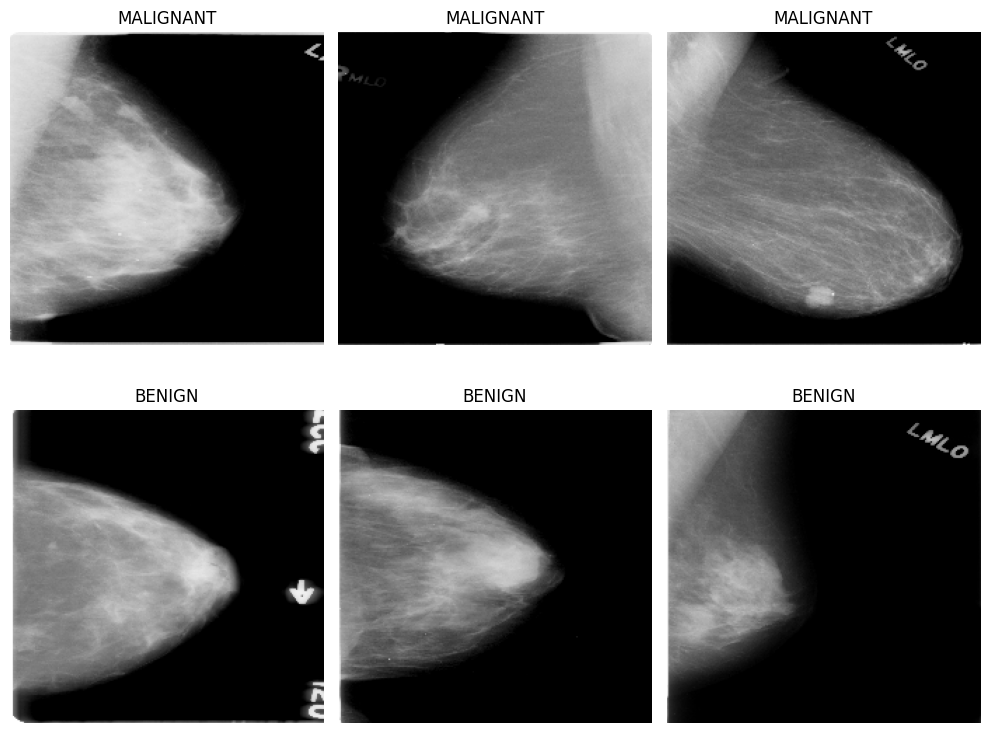

In [35]:
# Define a function to display images
def display_images(images, titles, rows, cols, figsize=(10, 8)):
    """Display a grid of images with titles"""
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display a sample of preprocessed images
sample_images = X_train[:6]  # Adjust the number of images to display
sample_labels = y_train[:6]  # Adjust labels accordingly

# Define titles for the images
class_names = ['BENIGN', 'MALIGNANT','BENIGN_WITHOUT_CALLBACK']  # Assuming 0 is benign and 1 is malignant
image_titles = [class_names[label] for label in sample_labels]

# Display the images
display_images(sample_images, image_titles, 2, 3)

In [36]:
from tensorflow.keras.applications import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l1_l2

In [37]:
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model


# Create the ResNet-101 base model
base_model = InceptionV3(weights='/kaggle/input/inception-v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Define regularization parameters
l1_reg = 0.001
l2_reg = 0.001
dropout_rate = 0.3

# Add new classification layers with regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
x = Dropout(dropout_rate)(x)  # Dropout layer to prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)

# Combine base model with new classification layers
model = Model(inputs=base_model.input, outputs=predictions)

#Adam
# Compile the model with initial learning rate
initial_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [38]:
# Define a learning rate scheduler (if needed)
def lr_schedule(epoch):
    # Learning Rate Schedule
    lr = initial_learning_rate
    if epoch > 10:
        lr *= 0.1
    elif epoch > 5:
        lr *= 0.5
    return lr

In [39]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Define the checkpoint directory and file name
checkpoint_filepath = 'path/to/your/checkpoint_directory/model-{epoch:02d}-{val_accuracy:.2f}.weights.h5'

# Create a ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [40]:
# Calculate mean and standard deviation of training data
mean = np.mean(X_train)
std = np.std(X_train)

# Normalize training and test data
X_train_normalized = (X_train - mean) / std
X_test_normalized = (X_test - mean) / std


In [41]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define training parameters
batch_size = 20
max_epochs = 50
num_iterations = 100
       
# Now, include the callback in your model.fit() call
history = model.fit(X_train_normalized, y_train,
                    batch_size=batch_size,
                    epochs=max_epochs,
                    steps_per_epoch=num_iterations,
                    validation_data=(X_test_normalized, y_test), 
                    callbacks=[LearningRateScheduler(lr_schedule), early_stopping, model_checkpoint_callback])      

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 41.7291 - accuracy: 0.6276
Epoch 1: val_accuracy improved from -inf to 0.65680, saving model to path/to/your/checkpoint_directory/model-01-0.66.weights.h5
100/100 [==============================] - 66s 218ms/step - loss: 41.7291 - accuracy: 0.6276 - val_loss: 35.0527 - val_accuracy: 0.6568 - lr: 1.0000e-04
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 29.1127 - accuracy: 0.7665
Epoch 2: val_accuracy improved from 0.65680 to 0.68639, saving model to path/to/your/checkpoint_directory/model-02-0.69.weights.h5
100/100 [==============================] - 17s 165ms/step - loss: 29.1127 - accuracy: 0.7665 - val_loss: 23.8430 - val_accuracy: 0.6864 - lr: 1.0000e-04
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 18.7859 - accuracy: 0.8943
Epoch 3: val_accuracy did not improve from 0.68639
100/100 [==============================] - 15s 154ms/step - loss: 18.7859 - accuracy: 0.8943 

In [42]:
# Get training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

In [43]:
# Get validation history
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

In [44]:
# Calculate overall training and validation loss and accuracy
overall_train_loss = np.mean(train_loss)
overall_train_accuracy = np.mean(train_accuracy)
overall_val_loss = np.mean(val_loss)
overall_val_accuracy = np.mean(val_accuracy)

# Print the overall accuracy
print("Overall Training Accuracy:", overall_train_accuracy)
print("Overall Validation Accuracy:", overall_val_accuracy)

Overall Training Accuracy: 0.9660191237926483
Overall Validation Accuracy: 0.7548323432604472


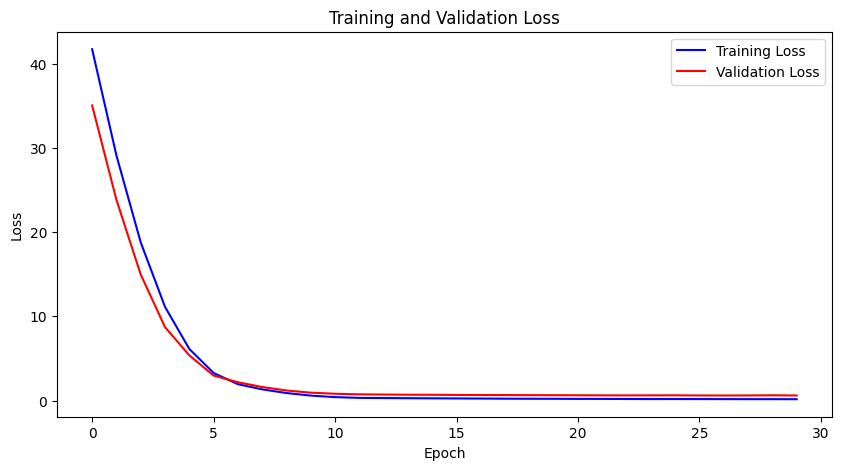

In [45]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

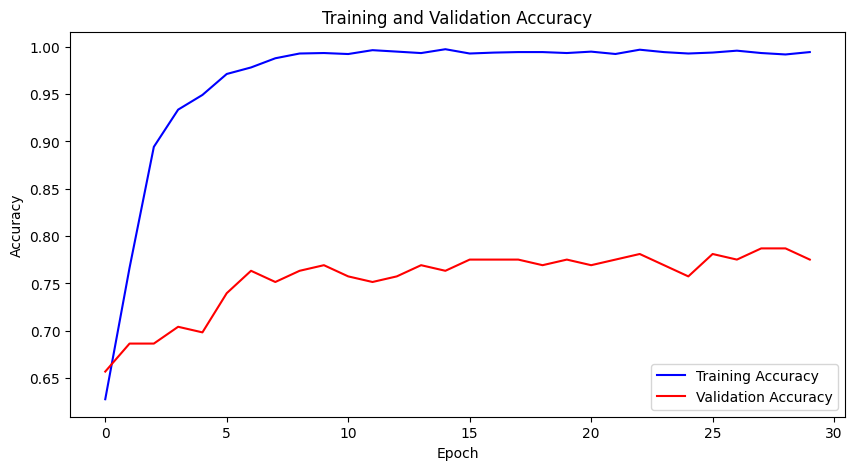

In [46]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [47]:
#y_test

In [48]:
#model.predict(X_test[0])
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions


# Load the pre-trained ResNet model
#model = ResNet101(weights='/kaggle/input/resnet101/resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))


# Preprocess the image
#img_path = 'your_image.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# img = image.img_to_array(img)
img = np.expand_dims(X_test[1], axis=0)
img = preprocess_input(img)

# Make predictions
predictions = model.predict(img)

# Decode predictions (optional, for ImageNet class labels)
# decoded_predictions = decode_predictions(predictions, top=1)[0]

# Print the results
#for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
#    print(f"{i + 1}: {label} ({score:.2f})")

# The top prediction can be accessed as decoded_predictions[0]


1/1 [==============================] - 2s 2s/step


In [49]:
predictions

array([[1.0592505e-12]], dtype=float32)

In [50]:
categorical_predictions = np.array(predictions, dtype=np.float32)

# Find the index of the class with the highest probability
predicted_class_index = np.argmax(categorical_predictions)

# Assuming class 0 and class 1
#full_mass['labels']
# 'MALIGNANT': 1, 'BENIGN': 0
class_labels = ["MALIGNANT", "BENIGN"]
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class label:", predicted_class_label)

Predicted class label: MALIGNANT


In [51]:
# model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

# Evaluation

In [52]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 2s 59ms/step - loss: 1.4922 - accuracy: 0.6154


[1.4921891689300537, 0.6153846383094788]

# ROC_AUC Curves

6/6 [==============================] - 0s 75ms/step


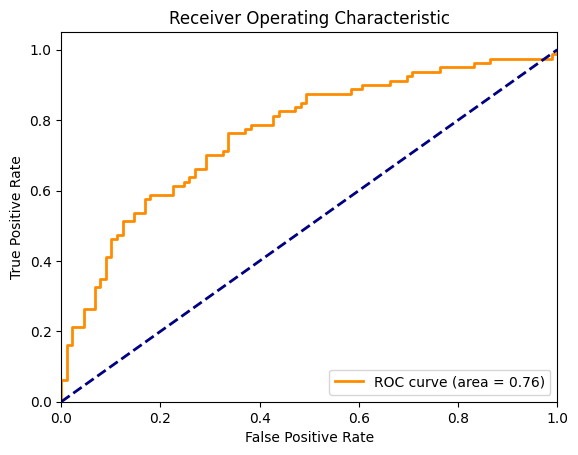

In [55]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test is your true binary labels and model is your trained model
# Get the predicted probabilities for the positive class (if sigmoid, model outputs one value)
y_pred_probs = model.predict(X_test).ravel()  # Use ravel() to flatten array if necessary

# Ensure y_test is a 1D array of binary labels (0s and 1s)
# If y_test is one-hot encoded, convert it to binary labels by taking the index of the max value
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test_binary = y_test.argmax(axis=1)
else:
    y_test_binary = y_test.ravel()  # Flatten and use as is if already binary labels

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Classification Report

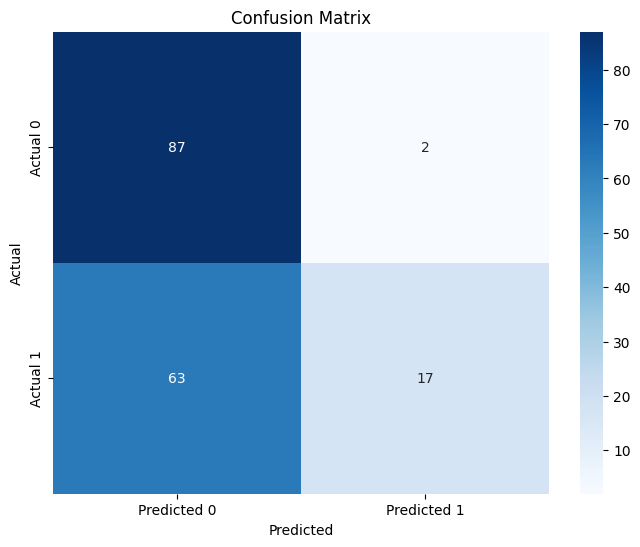

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have y_test and y_pred from the previous discussions
# If y_test is one-hot encoded, convert it to single labels:
if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)

# Assuming y_pred_probs are your model predictions
y_pred = (y_pred_probs > 0.5).astype(int)  # adjust threshold as needed

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [62]:
from sklearn.metrics import classification_report

# Assuming you have y_test and y_pred from the previous discussions
# If y_test is one-hot encoded, convert it to single labels:
if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)

# Assuming y_pred_probs are your model predictions
y_pred = (y_pred_probs > 0.5).astype(int)  # adjust threshold as needed

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

# Print the classification report
print(report)


              precision    recall  f1-score   support

     Class 0       0.58      0.98      0.73        89
     Class 1       0.89      0.21      0.34        80

    accuracy                           0.62       169
   macro avg       0.74      0.60      0.54       169
weighted avg       0.73      0.62      0.55       169



# Save Model

In [63]:
import tensorflow as tf

# Load your model
# model = tf.keras.applications.ResNet101(weights='imagenet', include_top=True)

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('bc_inception_v3.tflite', 'wb') as f:
    f.write(tflite_model)
